In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from SALib.sample import saltelli, latin, fast_sampler, morris
from SALib.sample import sobol as ssobol
from SALib.analyze import sobol, fast, rbd_fast, delta, pawn
from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample
from SALib.test_functions import Ishigami
from tqdm import tqdm


$\text{SALib Example}$

          ST   ST_conf
x1  0.555644  0.089435
x2  0.441259  0.037309
x3  0.243948  0.030256
          S1   S1_conf
x1  0.316418  0.056348
x2  0.442918  0.052115
x3 -0.000629  0.058278
                S2   S2_conf
(x1, x2) -0.005738  0.076827
(x1, x3)  0.241651  0.117455
(x2, x3) -0.000890  0.058777


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

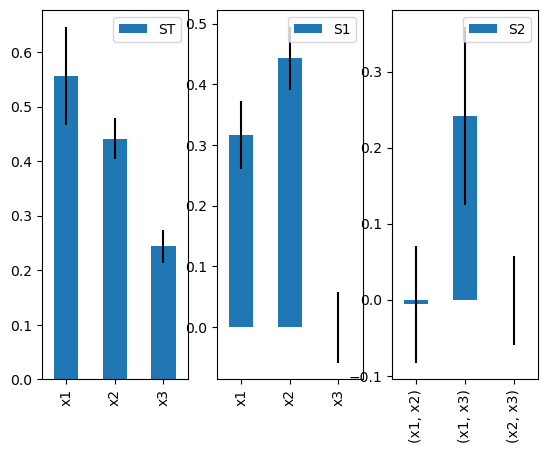

In [37]:
# Define the model inputs
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

# Generate samples
param_values = sample(problem, 1024)

# Run model (example)
Y = Ishigami.evaluate(param_values)

# Perform analysis
Si = analyze(problem, Y, print_to_console=True)

Si.plot()

$\text{ODE Example}$

In [38]:
# Define the ODE model
def model(y, t, params):
    k1, k2 = params
    dydt = [-k1 * y[0],
            k1 * y[0] - k2 * y[1],
            k2 * y[1]]
    return dydt

In [39]:
# Define parameter ranges
problem = {
    'num_vars': 2,
    'names': ['k1', 'k2'],
    'bounds': [[0.1, 0.5], [0.1, 0.5]]
}

In [40]:
# Generate samples
param_values = ssobol.sample(problem, 500)

# Define initial conditions and time points
y0 = [10, 0, 0]
t = np.linspace(0, 10, 100)

/Users/shivanimadhan/anaconda3/envs/kinetics/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [41]:
# Run the model for each sample
output = np.empty([param_values.shape[0], t.size, 3])
for i, params in enumerate(param_values):
    sol = odeint(model, y0, t, args=(params,))
    output[i] = sol

    # model = DeterministicModel()
    # model.solve(tspan)
    # output[i] = model.get_sequence_length
param_values.shape

(3000, 2)

In [42]:
def add_data_to_large_df(time_point, small_df, large_df):
    # Initialize a dictionary to store data to be appended
    data = {'time_point': time_point}
    
    # Loop through each row in the small DataFrame and extract the needed values
    for idx in small_df.index:
        data[f'{idx}_delta'] = small_df.loc[idx, 'delta']
        data[f'{idx}_delta_conf'] = small_df.loc[idx, 'delta_conf']
        data[f'{idx}_S1'] = small_df.loc[idx, 'S1']
        data[f'{idx}_S1_conf'] = small_df.loc[idx, 'S1_conf']

    df_row = pd.DataFrame([data])
    # Append the new row to the larger DataFrame
    # large_df = large_df.append(df_row, ignoreIndex=True)
    large_df = pd.concat([large_df, df_row], ignore_index=True)
    return large_df

In [43]:
df_large = pd.DataFrame(columns=['time_point'])


# Turn this into a function:
# - take in  problem, param_values, output, output_save_location
for i, t_point in tqdm(enumerate(t)):
    if (i == 0):
        continue
    

    Si = delta.analyze(problem, param_values, output[:, i, 2])
    # Si = delta.analyze(problem, param_values, model.nAvgSLA[i])
    df_large = add_data_to_large_df(t_point, Si.to_df(), df_large)

    # save dataframe
    

0it [00:00, ?it/s]/var/folders/zh/dpvqt3794n73s3md_1fs2wmr0000gn/T/ipykernel_97371/2738944218.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  large_df = pd.concat([large_df, df_row], ignore_index=True)
100it [08:07,  4.88s/it]


In [44]:
df_large.head()

,time_point,k1_delta,k1_delta_conf,k1_S1,k1_S1_conf,k2_delta,k2_delta_conf,k2_S1,k2_S1_conf
0,0.101010,0.318623,0.010671,0.470081,0.022483,0.296053,0.011599,0.457429,0.022198
1,0.202020,0.303767,0.011627,0.470551,0.023374,0.308373,0.011617,0.471522,0.025826
2,0.303030,0.326718,0.011189,0.461351,0.021803,0.325187,0.011163,0.472334,0.026161
3,0.404040,0.317625,0.010808,0.439758,0.024156,0.323790,0.012125,0.473631,0.025818
4,0.505051,0.311924,0.012617,0.464726,0.020598,0.323056,0.012502,0.457860,0.025895


In [45]:
def plot_data(ax, df_large, data_name, conf_name=None, color='k'):
    df = df_large


    # Plot the line graph
    ax.plot(df['time_point'], df[data_name], label=data_name, color=color)

    # Shade the confidence interval
    if conf_name is not None:
        ax.fill_between(df['time_point'], df[data_name] - df[conf_name], 
            df[data_name] + df[conf_name], color=color, alpha=0.3)

    # Add labels and title
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(data_name)
    if conf_name is not None:
        ax.set_title(data_name + ' with Confidence Interval')
    else:
        ax.set_title(data_name)

    # Add legend
    ax.legend()

    # Show plot
    ax.grid(True)
    # a.show()
    
    return ax

In [46]:
df_large.to_csv('df_large.csv', index=False)
df_large = pd.read_csv('df_large.csv')


# Experiments
# - Experiment 1: Vary the number of samples
# - - N_100.csv
# - - N_500.csv
# - - N_1000.csv
# - Experiment 2: Vary the number of time points
# - - T_50.csv
# - - T_100.csv
# - - T_200.csv

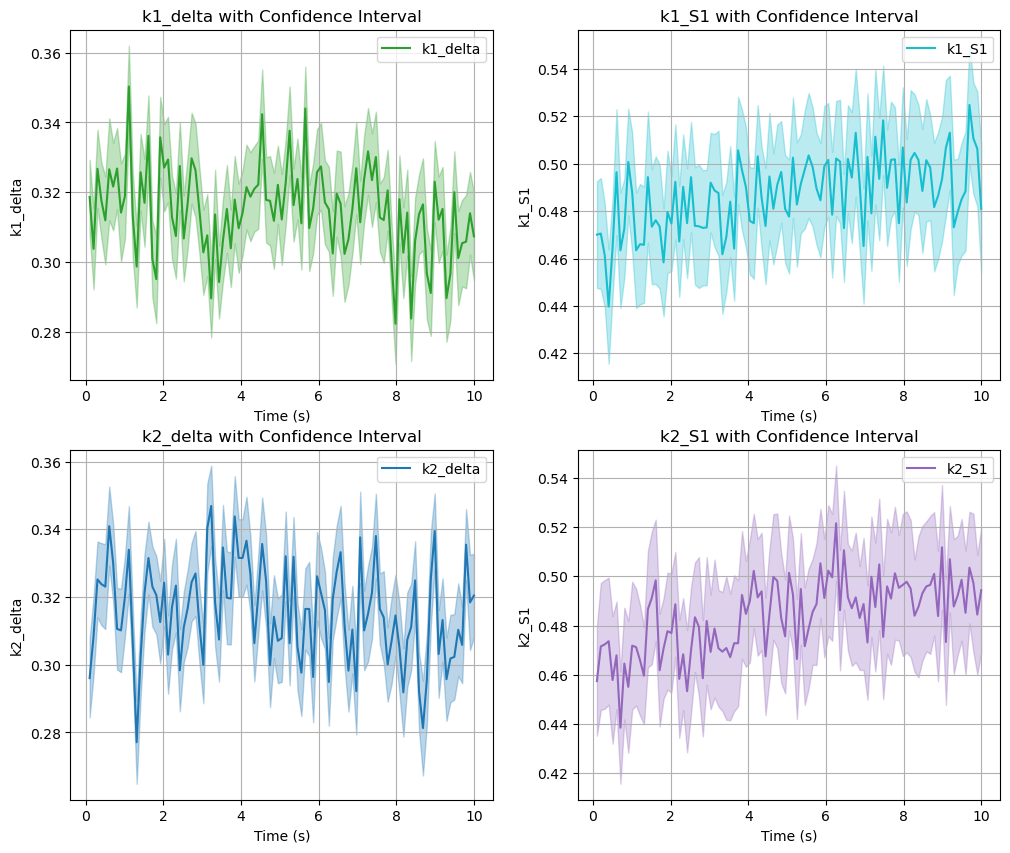

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), dpi=100)
ax1, ax2, ax3, ax4 = axs.flatten()

ax1 = plot_data(ax1, df_large, 'k1_delta', 'k1_delta_conf', 'tab:green')
ax2 = plot_data(ax2, df_large, 'k1_S1', 'k1_S1_conf', 'tab:cyan')
ax3 = plot_data(ax3, df_large, 'k2_delta', 'k2_delta_conf', 'tab:blue')
ax4 = plot_data(ax4, df_large, 'k2_S1', 'k2_S1_conf', 'tab:purple')
plt.show()

$\text{Kinetic ODEs}$